In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import pingouin as pg
import scikit_posthocs as sp  
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('churn.csv')
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [3]:
## Get Churn

In [4]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


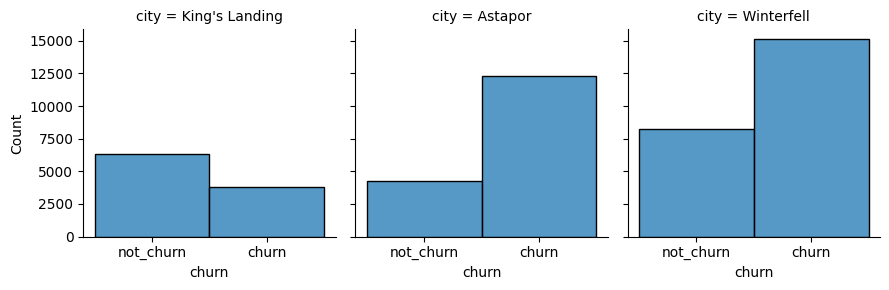

In [5]:
grid = sns.FacetGrid(df, col='city')
grid.map(sns.histplot, 'churn')

## Task 1

In [7]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [8]:
stat, p

(3821.5510225559633, 0.0)

## Task 2

<AxesSubplot: title={'center': 'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

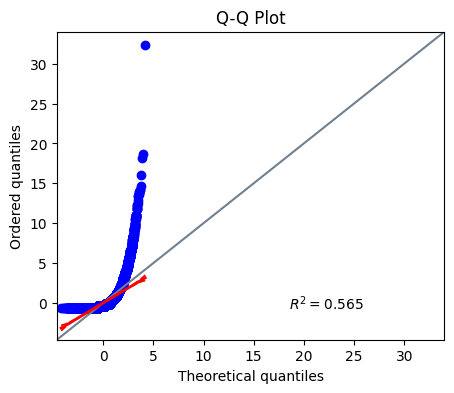

In [32]:
pg.qqplot(df.trips_in_first_30_days, dist='norm')

In [11]:
pg.normality(data=df, dv='trips_in_first_30_days', group='city', method='normaltest')

,W,pval,normal
King's Landing,12011.013892,0.0,False
Astapor,18186.739338,0.0,False
Winterfell,21390.545655,0.0,False


In [12]:
# answer Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса

## Task 3

In [14]:
kruskal(
    df.query("city == 'Astapor'").trips_in_first_30_days, 
    df.query("city == 'Winterfell'").trips_in_first_30_days, 
    df.query("city not in ('Winterfell', 'Astapor')").trips_in_first_30_days
)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

In [19]:
sp.posthoc_dunn(df, val_col='trips_in_first_30_days', group_col='city', p_adjust = 'holm')

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


## Task 4

Alternative: X < Y ==> Mean Trips In first 30 Days [Churn] < Mean Trips In first 30 Days Not Churn 

In [29]:
mannwhitneyu(df.query("churn == 'churn'").trips_in_first_30_days, df.query("churn == 'not_churn'").trips_in_first_30_days, alternative='less')

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

In [30]:
# ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ, УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ